In [9]:
import tensorflow as tf
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras import layers



In [3]:

def process(maps):
    return maps[:,:,0:3], maps[:,:,3:6], maps[:,:,6:8], maps[:,:,8] 

def normalisation(vec):
    return vec/tf.norm(vec,axis = -1)[:,:,None]

def GGXpxl(V,L,N,albedo,metallic,rough):
      
        albedo   = albedo/255
        metallic = tf.reduce_mean(metallic,axis = -1)/255# set to single value
        rough= (rough/255)**2

        H = normalisation(V+L)
        
        VdotH = tf.maximum(tf.reduce_sum(V*H,axis = -1),0)
        NdotH = tf.maximum(tf.reduce_sum(N*H,axis = -1),0)
        NdotV = tf.maximum(tf.reduce_sum(V*N,axis = -1),0)
        NdotL = tf.maximum(tf.reduce_sum(N*L,axis = -1),0)

        F = metallic+ (1 - metallic) * (1 - VdotH)**5
        NDF = 1 / (np.pi*rough*pow(NdotH,4.0))*tf.exp((NdotH * NdotH - 1.0) / (rough * NdotH * NdotH))
        G = tf.minimum(2*NdotH*NdotV/VdotH, 2*NdotH*NdotL/VdotH)
        G = tf.minimum(tf.cast(1,dtype = tf.float64) , G)

        nominator    = NDF* G * F 
        denominator = 4 * NdotV * NdotL + 0.001
        specular = nominator / denominator

        diffuse = (1-metallic)[:,:,None] * albedo / np.pi *NdotL[:,:,None] #*radiance

        reflection = specular * NdotL*4 #* radiance 
        reflection = tf.reshape(reflection,(288,288,1))

        color = tf.concat([reflection,reflection,reflection],-1) + diffuse*1
        #return tf.minimum(tf.cast(1,dtype = tf.float64),color)
        return color
        


def GGXtf(maps):
    maps = tf.squeeze(maps)
    lightpos = tf.Variable([1000,1000,1000],dtype = tf.float64)
    viewpos  = tf.Variable([143,143,300],dtype = tf.float64)

    albedomap, specularmap, normalinmap, roughnessmap = process(maps)
    
    shapex = int(maps.shape[0])
    shapey = int(maps.shape[1])

    x = np.linspace(0,shapex-1,shapex)
    y = np.linspace(0,shapey-1,shapey)
    xx,yy = tf.meshgrid(x,y)
    xx = tf.reshape(xx ,(shapex,shapey,1))
    yy = tf.reshape(yy ,(shapex,shapey,1))
    padd0 = tf.reshape(tf.zeros([shapex,shapey],dtype = tf.float64)    ,(shapex,shapey,1))
    padd1 = tf.reshape(tf.ones ([shapex,shapey],dtype = tf.float64)*255,(shapex,shapey,1))
    fragpos = tf.concat([xx,yy,padd0],axis = -1)

    N = normalisation(tf.concat([normalinmap,padd1],axis = -1)/255)
    V = normalisation(viewpos - fragpos)
    L = normalisation(lightpos - fragpos)

    imgout = GGXpxl(V ,L , N, albedomap,specularmap,roughnessmap)

    return  imgout




def l1_loss(mgt, mif):
    return tf.reduce_mean(tf.abs(mgt-mif))

def l2_loss(mgt, mif):
    return tf.reduce_mean(tf.square(mgt-mif))

def rendering_loss(mgt, mif):

    return l1_loss(GGXtf(mgt),GGXtf(mif))





d:\Y4\DNNreimplement\Deschaintre


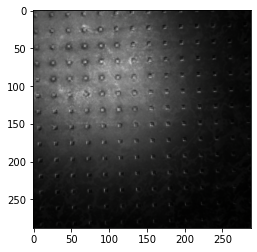

In [4]:
import os
from imageprocessing import imagestack
print(os.getcwd())
path = os.getcwd()+'\example.png'
#path = os.getcwd()+'\Deschaintre\example.png'
input, maps = imagestack(path)
x_train_noise = tf.convert_to_tensor(maps)
x_train = tf.convert_to_tensor(maps)
x_train = tf.expand_dims(x_train, axis=0)
x_train_noise = tf.expand_dims(x_train, axis=0)

out1 = GGXtf(x_train)

plt.imshow(out1)
plt.show()

In [72]:
from pathlib import Path
path = os.getcwd()+'\Deschaintre'
root = Path(path)
for item in root.glob("*"):
  print(item.name)

list_ds = tf.data.Dataset.list_files(str(root/'*'))

for f in list_ds.take(5):
  print(f.numpy())

def process_path(file_path):
  inputs, outputs = imagestack(file_path)
  inputs = tf.convert_to_tensor(inputs)
  outputs = tf.convert_to_tensor(outputs)
  inputs = tf.expand_dims(inputs, axis=0)
  outputs = tf.expand_dims(outputs, axis=0)
  return inputs, outputs

labeled_ds = list_ds.map(process_path)





0000022_camouflage_001Xmetal_006_5X5.png
0000023_camouflage_001Xmetal_006_12X1.png
0000024_camouflage_001Xmetal_006_12X1.png
0000025_skin_facial_hairXconcrete_085_5X7.png
0000026_skin_facial_hairXconcrete_085_5X7.png
0000027_skin_facial_hairXconcrete_085_5Xdefault.png
0000028_skin_facial_hairXconcrete_085_5Xdefault.png
0000029_metal_steel_bumpedXSmall_rocks_defaultX4.png
0000030_metal_steel_bumpedXSmall_rocks_defaultX4.png
0000031_marble_stoneXcamouflage_001_13X3.png
0000032_marble_stoneXcamouflage_001_13X3.png
0000033_Dark_Stone_TilesXBrick_Wall_2X8.png
0000034_Dark_Stone_TilesXBrick_Wall_2X8.png
0000035_Dark_Stone_TilesXBrick_Wall_12X1.png
b'd:\\Y4\\DNNreimplement\\Deschaintre\\Deschaintre\\0000028_skin_facial_hairXconcrete_085_5Xdefault.png'
b'd:\\Y4\\DNNreimplement\\Deschaintre\\Deschaintre\\0000031_marble_stoneXcamouflage_001_13X3.png'
b'd:\\Y4\\DNNreimplement\\Deschaintre\\Deschaintre\\0000026_skin_facial_hairXconcrete_085_5X7.png'
b'd:\\Y4\\DNNreimplement\\Deschaintre\\Deschaint

In [37]:
from pathlib import Path
path = os.getcwd()+'\Dataset'
print(path)
datagen = ImageDataGenerator()
data = datagen.flow_from_directory(path)
print(data)

d:\Y4\DNNreimplement\Deschaintre\Dataset
Found 14 images belonging to 2 classes.


In [62]:

print(x_train.shape)
model = keras.models.Sequential()
model.add(layers.Input(shape=(288,288) + (9,),dtype=tf.float64))
model.add(layers.Layer())

model.compile(optimizer = 'Adam', loss = rendering_loss, metrics = ['mse'])

model.fit(x_train_noise, x_train, batch_size=1, epochs=10, validation_split=0.1)


(1, 288, 288, 9)

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



ValueError: Training data contains 1 samples, which is not sufficient to split it into a validation and training set as specified by `validation_split=0.1`. Either provide more data, or a different value for the `validation_split` argument.

11493376/11490434 [==============================] - 6s 1us/step
(60000, 784)


In [ ]:
def SVBRDF(num_classes):
    #=============== first layer ==================

    inputs = keras.Input(shape=(288,288) + (3,))
    x = layers.LeakyReLU()(inputs)
    GF = layers.AveragePooling2D(x.shape[1])(x)
    GF = layers.Dense(128)(GF)
    GF = layers.Activation('selu')(GF)
    x = layers.SeparableConv2D(128,4, 2, padding="same")(x)
    #previous_block_activation = x  # Set aside residual

    #========== define filters for unet ===================

    downfilters = np.array([128,256,512,512,512,512,512,512])
    Upfilters = np.flip(np.copy(downfilters))
    downfilters = np.delete(downfilters,0)
    #print(downfilters)
    prefilter = 128

    #===================== upsampling =======================

    for filters in downfilters:
        #print(x.shape)
        #print(filters)
        GFdown = layers.AveragePooling2D(x.shape[1])(x)
        GFup   = layers.Dense(prefilter)(x)
        GF     = layers.Concatenate()([GF,GFdown])
        GF = layers.Dense(filters)(GF)
        GF = layers.Activation('selu')(GF)
        
        x = layers.Add()([x,GFup])
        x = layers.LeakyReLU()(x)
        x = layers.SeparableConv2D(filters, 4,2, padding="same")(x)
        prefilter = filters
        #x = layers.BatchNormalization()(x)
        # Project residual

        #residual = layers.Conv2D(filters, 4,2, padding="same")(previous_block_activation)
        #x = layers.add([x, residual])  # Add back residual
        #previous_block_activation = x  # Set aside next residual

    #====================== downsampling ============================

    for filters in Upfilters:

        GFdown = layers.AveragePooling2D(x.shape[1])(x)
        GFup   = layers.Dense(prefilter)(x)
        GF     = layers.Concatenate()([GF,GFdown])
        GF = layers.Dense(filters)(GF)
        GF = layers.Activation('selu')(GF)
        
        x = layers.Add()([x,GFup])
        x = layers.LeakyReLU()(x)
        x = layers.Conv2DTranspose(filters, 4,2, padding="same")(x)
        prefilter = filters
        
        # Project residual
        #residual = layers.UpSampling2D(2)(previous_block_activation)
        #residual = layers.Conv2D(filters, 4, padding="same")(residual)
        #x = layers.add([x, residual])  # Add back residual
        #previous_block_activation = x  # Set aside next residual

    #====================== last connection =====================

    GFup   = layers.Dense(prefilter)(x)
    x = layers.Add()([x,GFup])
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)
    model = keras.Model(inputs, outputs)
    return model



In [ ]:
model = SVBRDF(9)
model.compile(optimizer = 'Adam', loss = rendering_loss, metrics = ['mse'])
model.fit(x_train_noise, x_train, batch_size=128, epochs=10, validation_split=0.1)